# Intelligent Control (ECE-DK807)

## Electrical and Computer Engineering Department, University of Patras Greece

**Instructor:** Konstantinos Chazilygeroudis (costashatz@upatras.gr)

## Lab 2

### 2D Cliff World

*(Taken from "Reinforcement Learning: An Introduction, 2nd Edition, Richard S. Sutton, Andrew G. Barto, 2015, MIT Press.")*

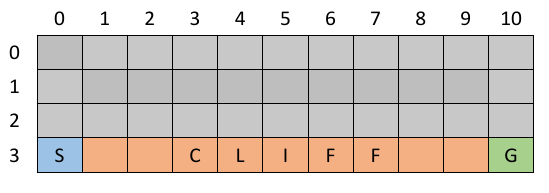

- S (blue) is the starting position
- G (green) is the goal
- Orange cells are cliff cells

At each timestep, the agent can be in only one cell. The agent has available the following actions:

1. Move Up
2. Move Down
3. Move Right
4. Move Left

If a move would make the agent go "out of bounds", then the move has no effect and the agent remains in place. The agent receives the following rewards:

- $-1$ for each step
- $-100$ for falling of the cliff
- $0$ for stepping on goal

The environment "stops" when the agent reaches the goal or steps falls off the cliff.

We first need to define the *Markov Decision Process* (MDP) for this problem/world.

In [1]:
# Let's first import modules
import numpy as np # Linear Algebra
import matplotlib.pyplot as plt # Plotting
import copy

In [2]:
### TO-DO: Define the state space. We want to define each cell with a tuple (i,j), and we want to save all cells/states in a list called 'states' (x goes from 0 to 3 and y from 0 to 10).
### ANSWER: Insert code here
(rows, cols) = (4, 11)
states = [(i, j) for i in range(rows) for j in range(cols)]
### END of ANSWER

def is_cliff(s):
    return (s[0] == 3 and s[1] > 0 and s[1] < 10)

def is_terminal(s):
    return (s == (3, 10))

### TO-DO: Define the action space. This is a list of all possible actions. Save it in a variable named 'actions'.
### ANSWER: Insert code here
actions = ['Move Up', 'Move Down', 'Move Right', 'Move Left']

move_offsets = {
    actions[0]: (-1, 0), # Up
    actions[1]: (+1, 0), # Down
    actions[2]: (0, +1), # Right
    actions[3]: (0, -1)  # Left
}
### END of ANSWER

### TO-DO: Define a world_step function (aka the system dynamics). The function takes as input the currest state (state) and the action to perform and returns the new state (a tuple).
def world_step(state, action):
    ### ANSWER: Insert code here
    sp = tuple(map(sum, zip(state, move_offsets[action])))
    
    if is_terminal(state):
        sp = state
    elif is_cliff(state):
        sp = state
    elif sp[0] < 0 or sp[0] >= rows or sp[1] < 0 or sp[1] >= cols:
        sp = state
        
    return sp;
    ### END of ANSWER

# Let's define the reward table/function
reward = {}
for s in states:
    for a in actions:
        reward[(s, a)] = -1.
        ### TO-DO: Fill with values
        ### ANSWER: Insert code here
        sp = world_step(s, a)
        if is_terminal(sp):
            reward[(s, a)] = 0
        elif is_cliff(sp):
            reward[(s, a)] = -100
        ### END of ANSWER

In [3]:
assert(len(states) == 44)
assert(len(actions) == 4)


In [4]:
for a in actions:
    assert(reward[((1, 1), a)] == -1.)
    
assert(reward[((3, 1), 'Move Right')] == reward[((3, 2), 'Move Right')] == -100.)
assert(reward[((3, 10), 'Move Right')] == 0.)


### SARSA: On-Policy TD Learning

1. Initialize $Q(\boldsymbol{s},\boldsymbol{a})=0, \forall\boldsymbol{s}\in\mathcal{S}, \forall\boldsymbol{a}\in\mathcal{A}$
2. At every step:
   1. we observe the state $\boldsymbol{s}$
   2. we select and execute an action according to our policy $\boldsymbol{a}\sim\pi(\boldsymbol{s})$
   3. we end up at state $\boldsymbol{s}'$ and receive reward $r$
   4. we select $\boldsymbol{a}'$ using $Q$ and $\boldsymbol{s}'$ (e.g. using $\epsilon-\text{greedy}$)
   5. $Q(\boldsymbol{s},\boldsymbol{a}) = Q(\boldsymbol{s},\boldsymbol{a}) + \alpha\Big(r + \gamma Q(\boldsymbol{s}',\boldsymbol{a}') - Q(\boldsymbol{s},\boldsymbol{a})\Big)$

Let's implement it.

In [5]:
# First let's create the Q-function
N_states = len(states)
N_actions = len(actions)

# No need to keep an explicit policy representation, only the Q function is needed
Q = {}
### TO-DO: Initialize Q-function with zeros for all states. Q function is a dictionary that keys are tuples of the form (s,a)
### ANSWER: Insert code here
Q = {(s, a): 0. for s in states for a in actions}
### END of ANSWER

# Policy given the Q-function
def pi(s, behavior="greedy", epsilon=0.1):
    ### TO-DO: Create ε-greedy policy. The function should return an action.
    ### ANSWER: Insert code here
    if behavior == 'greedy':
        return max(actions, key = lambda a: Q[(s, a)]);
    
    if np.random.rand() < epsilon:
        return np.random.choice(actions); # Explore
    return max(actions, key = lambda a: Q[(s, a)]); # Exploit
    ### END of ANSWER

In [6]:
for s in states:
    assert(Q[s, 'Move Right'] == 0.)


In [7]:
# For testing
np.random.seed(1) # fix seed for testing
Q[(0, 0), 'Move Right'] = 10.

assert(pi((0, 0), "stochastic") == 'Move Right')


# Reset state
np.random.seed(None)
Q[(0, 0), 'Move Right'] = 0.

In [8]:
# Now we need to interact with the environment
N_episodes = 1000
gamma = 1. # episodic setting
alpha = 0.25
epsilon = 0.1
max_steps = 500

all_rewards = [] # for plotting
previous_reward = None
alpha_reward = 0.8

np.random.seed(5) # fix seed for testing

for i in range(N_episodes):
    ### TO-DO: Reset the world to the initial state. In other words, set the variable named 'state' with the value of the initial state (a tuple)
    ### ANSWER: Insert code here
    state = (3, 0)
    ### END of ANSWER

    # let's run one episode and collect the data
    rewards = []

    for _ in range(max_steps):
        # we use the stochastic policy during learning
        ### TO-DO: Sample an action using the `pi` function. The action should be saved in a variable named 'action'
        ### ANSWER: Insert code here
        action = pi(state, behavior = 'stochastic')
        ### END of ANSWER
        # We now move the world one step with `world_step`
        next_state = world_step(state, action)

        ### TO-DO: Compute the reward. The reward should be saved in a variable named 'r'. 
        ### ANSWER: Insert code here
        r = reward[(state, action)]
        ### END of ANSWER

        # We check if the episode is finished or not
        done = is_cliff(next_state) or is_terminal(next_state)

        # Book-keeping
        rewards.append(r)
        #print(state, action, next_state, r, done)

        ### TO-DO: Implement SARSA update
        ### ANSWER: Insert code here
        ap = pi(next_state, behavior = 'stochastic')
        Q[(state, action)] += alpha * (r + gamma * Q[(next_state, ap)] - Q[(state, action)])
        ### END of ANSWER
        if done:
            break
        state = copy.copy(next_state)
    if previous_reward is None:
        previous_reward = np.sum(rewards)
    else:
        previous_reward = alpha_reward * previous_reward + (1. - alpha_reward) * np.sum(rewards)
    #print("Episode #" + str(i) + ": " + str(previous_reward))
    all_rewards.append(previous_reward)
    
#print(all_rewards)

In [9]:
assert(np.isclose(all_rewards[0], -65.))
assert(np.isclose(all_rewards[4], -97.25439999999999))
assert(np.isclose(all_rewards[-1], -16.677367188390097))


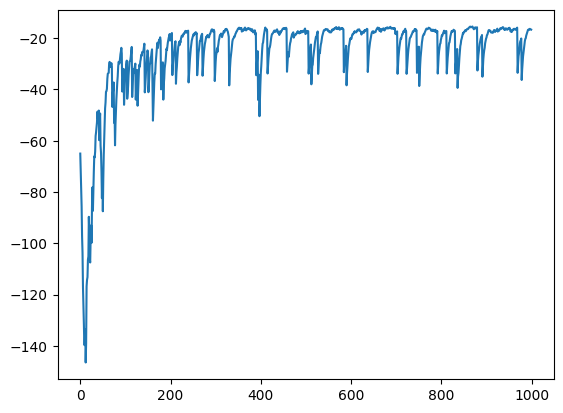

In [10]:
# Let's plot the learning process
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(range(len(all_rewards)), all_rewards, label='SARSA')

plt.show();

In [11]:
# Now let's do an episode with the greedy policy (aka the best learned)
np.random.seed(5) # fix seed for testing

### TO-DO: Reset the world to the initial state. In other words, set the variable named 'state' with the value of the initial state (a tuple)
### ANSWER: Insert code here
state = (3, 0)
### END of ANSWER

# let's run one episode and collect the data
rewards = []

for _ in range(max_steps):
    ### TO-DO: Sample an action using the `pi` function. The action should be saved in a variable named 'action'. Now use the greedy action!
    ### ANSWER: Insert code here
    action = pi(state, behavior = 'greedy')
    ### END of ANSWER
    # We now move the world one step with `world_step`
    next_state = world_step(state, action)

    ### TO-DO: Compute the reward. The reward should be saved in a variable named 'r'. 
    ### ANSWER: Insert code here
    r = reward[(state, action)]
    ### END of ANSWER

    # We check if the episode is finished or not
    done = is_cliff(next_state) or is_terminal(next_state)

    # Book-keeping
    rewards.append(r)

    if done:
        break
    state = copy.copy(next_state)
print('Episode reward is:', np.sum(rewards))

Episode reward is: -15.0


In [12]:
assert(np.isclose(np.sum(rewards), -15.))

### Q-Learning: Off-Policy TD Learning

1. Initialize $Q(\boldsymbol{s},\boldsymbol{a})=0, \forall\boldsymbol{s}\in\mathcal{S}, \forall\boldsymbol{a}\in\mathcal{A}$
2. At every step:
   1. we observe the state $\boldsymbol{s}$
   2. we select and execute an action according to our policy $\boldsymbol{a}\sim\pi(\boldsymbol{s})$
   3. we end up at state $\boldsymbol{s}'$ and receive reward $r$
   4. $Q(\boldsymbol{s},\boldsymbol{a}) = Q(\boldsymbol{s},\boldsymbol{a}) + \alpha\Big(r + \gamma\max_zQ(\boldsymbol{s}',\boldsymbol{z}) - Q(\boldsymbol{s},\boldsymbol{a})\Big)$

Let's implement it.

In [13]:
# First let's create the Q-function -- just copy paste from SARSA
N_states = len(states)
N_actions = len(actions)

# No need to keep an explicit policy representation, only the Q function is needed
Q = {}
### TO-DO: Initialize Q-function with zeros for all states. Q function is a dictionary that keys are tuples of the form (s,a). Copy paste from above.
### ANSWER: Insert code here
Q = {(s, a): 0. for s in states for a in actions}
### END of ANSWER

In [14]:
# Now we need to interact with the environment
N_episodes = 1000
gamma = 1. # episodic setting
alpha = 0.25
epsilon = 0.1
max_steps = 500

all_rewards_q = [] # for plotting
previous_reward = None
alpha_reward = 0.8

np.random.seed(5) # fix seed for testing

for i in range(N_episodes):
    ### TO-DO: Reset the world to the initial state. In other words, set the variable named 'state' with the value of the initial state (a tuple)
    ### ANSWER: Insert code here
    state = (3, 0)
    ### END of ANSWER

    # let's run one episode and collect the data
    rewards = []

    for _ in range(max_steps):
        # we use the stochastic policy during learning
        ### TO-DO: Sample an action using the `pi` function. The action should be saved in a variable named 'action'
        ### ANSWER: Insert code here
        action = pi(state, behavior = 'stochastic')
        ### END of ANSWER
        # We now move the world one step with `world_step`
        next_state = world_step(state, action)

        ### TO-DO: Compute the reward. The reward should be saved in a variable named 'r'.
        ### ANSWER: Insert code here
        r = reward[(state, action)]
        ### END of ANSWER

        # We check if the episode is finished or not
        done = is_cliff(next_state) or is_terminal(next_state)

        # Book-keeping
        rewards.append(r)
        # print(state, actions[action], next_state, r, done)

        ### TO-DO: Implement Q-learning update
        ### ANSWER: Insert code here
        max_Q_sp = max([Q[(next_state, z)] for z in actions])
        Q[(state, action)] += alpha * (r + gamma * max_Q_sp - Q[(state, action)])
        ### END of ANSWER
        if done:
            break
        state = copy.copy(next_state)
    if previous_reward is None:
        previous_reward = np.sum(rewards)
    else:
        previous_reward = alpha_reward * previous_reward + (1. - alpha_reward) * np.sum(rewards)
    # print("Episode #" + str(i) + ": " + str(previous_reward))
    all_rewards_q.append(previous_reward)

In [15]:
assert(np.isclose(all_rewards_q[0], -108.))
assert(np.isclose(all_rewards_q[4], -124.536))
assert(np.isclose(all_rewards_q[-1], -29.1192530203508))


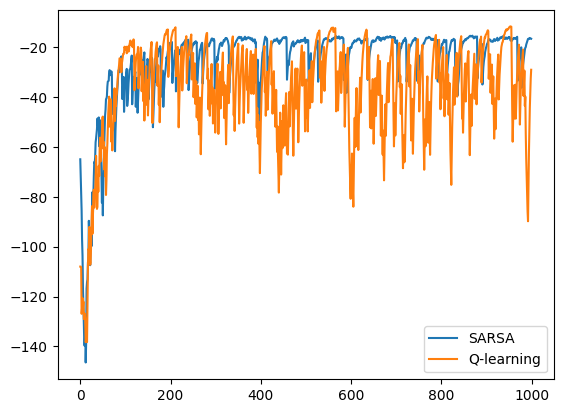

In [16]:
# Let's plot the learning process
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(range(len(all_rewards)), all_rewards, label='SARSA')
ax.plot(range(len(all_rewards)), all_rewards_q, label='Q-learning')

ax.legend()

plt.show();

In [17]:
# Now let's do an episode with the greedy policy (aka the best learned)
np.random.seed(5) # fix seed for testing

### TO-DO: Reset the world to the initial state. In other words, set the variable named 'state' with the value of the initial state (a tuple)
### ANSWER: Insert code here
state = (3, 0)
### END of ANSWER

# let's run one episode and collect the data
rewards = []

for _ in range(max_steps):
    ### TO-DO: Sample an action using the `pi` function. The action should be saved in a variable named 'action'. Now use the greedy action!
    ### ANSWER: Insert code here
    action = pi(state, behavior = 'greedy')
    ### END of ANSWER
    # We now move the world one step with `world_step`
    next_state = world_step(state, action)

    ### TO-DO: Compute the reward. The reward should be saved in a variable named 'r'. 
    ### ANSWER: Insert code here
    r = reward[(state, action)]
    ### END of ANSWER

    # We check if the episode is finished or not
    done = is_cliff(next_state) or is_terminal(next_state)

    # Book-keeping
    rewards.append(r)

    if done:
        break
    state = copy.copy(next_state)
print('Episode reward is:', np.sum(rewards))

Episode reward is: -11.0


In [18]:
assert(np.isclose(np.sum(rewards), -11.))

### Expected SARSA: Off-Policy TD Learning

1. Initialize $Q(\boldsymbol{s},\boldsymbol{a})=0, \forall\boldsymbol{s}\in\mathcal{S}, \forall\boldsymbol{a}\in\mathcal{A}$
2. At every step:
   1. we observe the state $\boldsymbol{s}$
   2. we select and execute an action according to our policy $\boldsymbol{a}\sim\pi(\boldsymbol{s})$
   3. we end up at state $\boldsymbol{s}'$ and receive reward $r$
   4. $Q(\boldsymbol{s},\boldsymbol{a}) = Q(\boldsymbol{s},\boldsymbol{a}) + \alpha\Big(r + \gamma\sum_{a'}[\pi(\boldsymbol{a}'|\boldsymbol{s}')Q(\boldsymbol{s}',\boldsymbol{a}')] - Q(\boldsymbol{s},\boldsymbol{a})\Big)$

Let's implement it.

In [19]:
# First let's create the Q-function -- just copy paste from previous
N_states = len(states)
N_actions = len(actions)

# No need to keep an explicit policy representation, only the Q function is needed
Q = {}
### TO-DO: Initialize Q-function with zeros for all states. Q function is a dictionary that keys are tuples of the form (s,a). Copy paste from above.
### ANSWER: Insert code here
Q = {(s, a): 0. for s in states for a in actions}
### END of ANSWER

In [20]:
# Now we need to interact with the environment
N_episodes = 1000
gamma = 1. # episodic setting
alpha = 0.25
epsilon = 0.1
max_steps = 500

all_rewards_es = [] # for plotting
previous_reward = None
alpha_reward = 0.8

np.random.seed(5) # fix seed for testing

for i in range(N_episodes):
    ### TO-DO: Reset the world to the initial state. In other words, set the variable named 'state' with the value of the initial state (a tuple)
    ### ANSWER: Insert code here
    state = (3, 0)
    ### END of ANSWER

    # let's run one episode and collect the data
    rewards = []

    for _ in range(max_steps):
        # we use the stochastic policy during learning
        ### TO-DO: Sample an action using the `pi` function. The action should be saved in a variable named 'action'
        ### ANSWER: Insert code here
        action = pi(state, behavior = 'stochastic')
        ### END of ANSWER
        # We now move the world one step with `world_step`
        next_state = world_step(state, action)

        ### TO-DO: Compute the reward. The reward should be saved in a variable named 'r'.
        ### ANSWER: Insert code here
        r = reward[(state, action)]
        ### END of ANSWER

        # We check if the episode is finished or not
        done = is_cliff(next_state) or is_terminal(next_state)

        # Book-keeping
        rewards.append(r)
        # print(state, actions[action], next_state, r, done)

        ### TO-DO: Implement Expected-SARSA update
        ### ANSWER: Insert code here
        q_values = np.array([Q[(next_state, ap)] for ap in actions], dtype=np.float64)
        softmax_probs = np.exp(q_values)
        softmax_probs /= softmax_probs.sum()
        expected_Q_sp = np.dot(softmax_probs, q_values)
        
        Q[(state, action)] += alpha * (r + gamma * expected_Q_sp - Q[(state, action)])
        ### END of ANSWER
        if done:
            break
        state = copy.copy(next_state)
    if previous_reward is None:
        previous_reward = np.sum(rewards)
    else:
        previous_reward = alpha_reward * previous_reward + (1. - alpha_reward) * np.sum(rewards)
    # print("Episode #" + str(i) + ": " + str(previous_reward))
    all_rewards_es.append(previous_reward)

In [21]:
assert(np.isclose(all_rewards_es[0], -108.))
assert(np.isclose(all_rewards_es[4], -107.456))
assert(np.isclose(all_rewards_es[-1], -30.25284672079732))


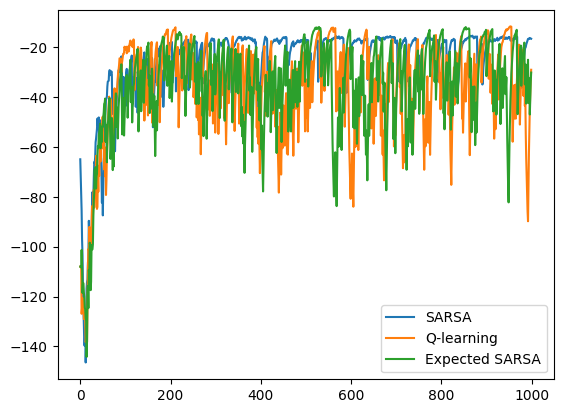

In [22]:
# Let's plot the learning process
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(range(len(all_rewards)), all_rewards, label='SARSA')
ax.plot(range(len(all_rewards)), all_rewards_q, label='Q-learning')
ax.plot(range(len(all_rewards)), all_rewards_es, label='Expected SARSA')

ax.legend()

plt.show();

In [23]:
# Now let's do an episode with the greedy policy (aka the best learned)
np.random.seed(5) # fix seed for testing

### TO-DO: Reset the world to the initial state. In other words, set the variable named 'state' with the value of the initial state (a tuple)
### ANSWER: Insert code here
state = (3, 0)
### END of ANSWER

# let's run one episode and collect the data
rewards = []

for _ in range(max_steps):
    ### TO-DO: Sample an action using the `pi` function. The action should be saved in a variable named 'action'. Now use the greedy action!
    ### ANSWER: Insert code here
    action = pi(state, behavior = 'greedy')
    ### END of ANSWER
    # We now move the world one step with `world_step`
    next_state = world_step(state, action)

    ### TO-DO: Compute the reward. The reward should be saved in a variable named 'r'. 
    ### ANSWER: Insert code here
    r = reward[(state, action)]
    ### END of ANSWER

    # We check if the episode is finished or not
    done = is_cliff(next_state) or is_terminal(next_state)

    # Book-keeping
    rewards.append(r)

    if done:
        break
    state = copy.copy(next_state)
print('Episode reward is:', np.sum(rewards))

Episode reward is: -11.0


In [24]:
assert(np.isclose(np.sum(rewards), -11.))